<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Define-transforms-and-model" data-toc-modified-id="Define-transforms-and-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define transforms and model</a></span></li><li><span><a href="#Define-metrics-and-model" data-toc-modified-id="Define-metrics-and-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define metrics and model</a></span></li><li><span><a href="#Train!" data-toc-modified-id="Train!-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train!</a></span></li><li><span><a href="#Visualize-results" data-toc-modified-id="Visualize-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualize results</a></span></li></ul></div>

(Raw data) -[DataParser]-> (Records) -[Transforms]-> (Dataset) -> (DataLoader)

(Lightning) -> (RCNNModel{Mid Level API}) -> (Learner{High Level API})

## Load Data

In [1]:
from mantisshrimp.all import *
import pandas as pd

The labels for the wheat dataset comes from a `.csv` file, let's use pandas to read that and show the first few items.

In [2]:
source = Path('/home/lgvaz/.data/wheat')

In [3]:
df = pd.read_csv(source/'train.csv'); df.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

Often the step of getting our data into a standard format is the most difficult one. Almost all datasets comes in their unique own format, and writing custom code to handle each one of them can be very time consuming.

Mantisshrimp provides an easy `Parser` interface for handling that, the main idea is that you only have to define how to parse a single sample and the library takes care of the rest.

There are two types of parsers we have to define:
* `InfoParser`: Parses metadata information about our images, like the image `id`, `file_path`, `height` and `width`.
* `AnnotationParser`: Parses our annotations, like bounding boxes, masks and keypoints.

Let's first define the `InfoParser` for our wheat dataset, since all the necessary information is already on the dataframe, this process will be very straight forward.

Each function defined receives a single item and should return it's appropriate value.

In [4]:
class WheatInfoParser(ImageParser):
    def iid(self, o): return o.image_id
    def height(self, o): return o.height
    def width(self, o): return o.width
    # Our images have the same name as their id, and are located under the 'train' folder
    def file_path(self, o): return self.source/f'train/{o.image_id}.jpg'
    # How to iterate over our data, `.itertuples()` will iterate over all rows of our dataframe
    def __iter__(self): yield from self.data.itertuples()

In [5]:
class WheatAnnotationParser(AnnotationParser):
    def iid(self, o): return o.image_id
    # Since we have only one class (wheat) we can always return 0 (or any constant other value)
    def oid(self, o): return 0
    # We first need to convert the bbox from a string to an array
    # Then we use the `.xywh` classmethod to specify the format of our bbox
    def bbox(self, o): return BBox.from_xywh(*np.fromstring(o.bbox[1:-1], sep=','))
    # Same thing as before, `.itertuples()` will iterate over all rows of our dataframe
    def __iter__(self): yield from df.itertuples()

A `CategoryMap` is an object that maps each category `name` and it's `id`, in our case it will contain a single `Category`.

In [6]:
catmap = CategoryMap([Category(0, 'wheat')])

We are now ready to create our `DataParser`, calling the `parse` method will parse all our data and return train and validation `Record`s (by default we use a 0.8/0.2 split)

In [7]:
parser = DataParser(df, source, catmap=catmap, img_parser=WheatInfoParser, annot_parser=WheatAnnotationParser)
train_rs,valid_rs = parser.parse()


Removed 0 images that don't have annotations


We can visualize a record with the `show_record` function.

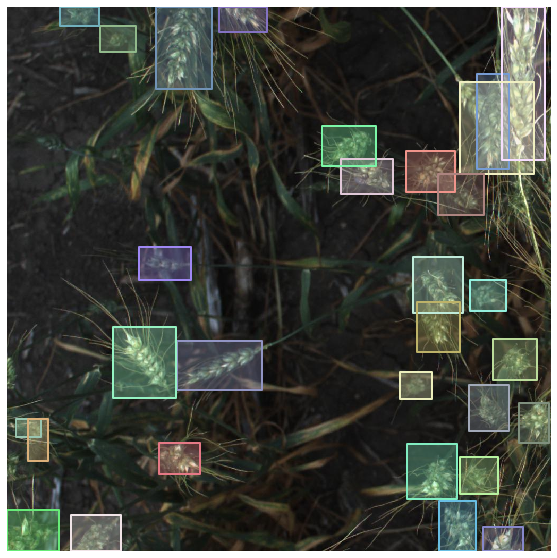

In [8]:
show_record(train_rs[6], label=False)

## Define transforms and model 

Mantisshrimp currently supports the [albumentations](https://github.com/albumentations-team/albumentations) library out of the box (more to come), if you need to use another library all you need to do is inherit from `Tfm` and override the `apply` method, real easy (take a look at how `AlbumTfm` is implemented for better a understading).

In [9]:
tfm = AlbuTfm([A.Flip(), A.ShiftScaleRotate(p=.7)])

The next step is to create a `Dataset`, a `Dataset` is a simple class that holds your `Records` and apply the defined transforms lazily.  
We don't want to apply our transforms to the validation dataset (since they're all augmentation transforms)

In [10]:
train_ds = Dataset(train_rs, tfm)
valid_ds = Dataset(valid_rs)

Now we're ready to create our dataloaders with `RCNNDataLoader`. The first argument should be our just created `Dataset` and all other arguments are the same as in the pytorch `DataLoader`.

In [11]:
train_dl = RCNNDataLoader(train_ds, batch_size=4, num_workers=8)
valid_dl = RCNNDataLoader(valid_ds, batch_size=4, num_workers=8)

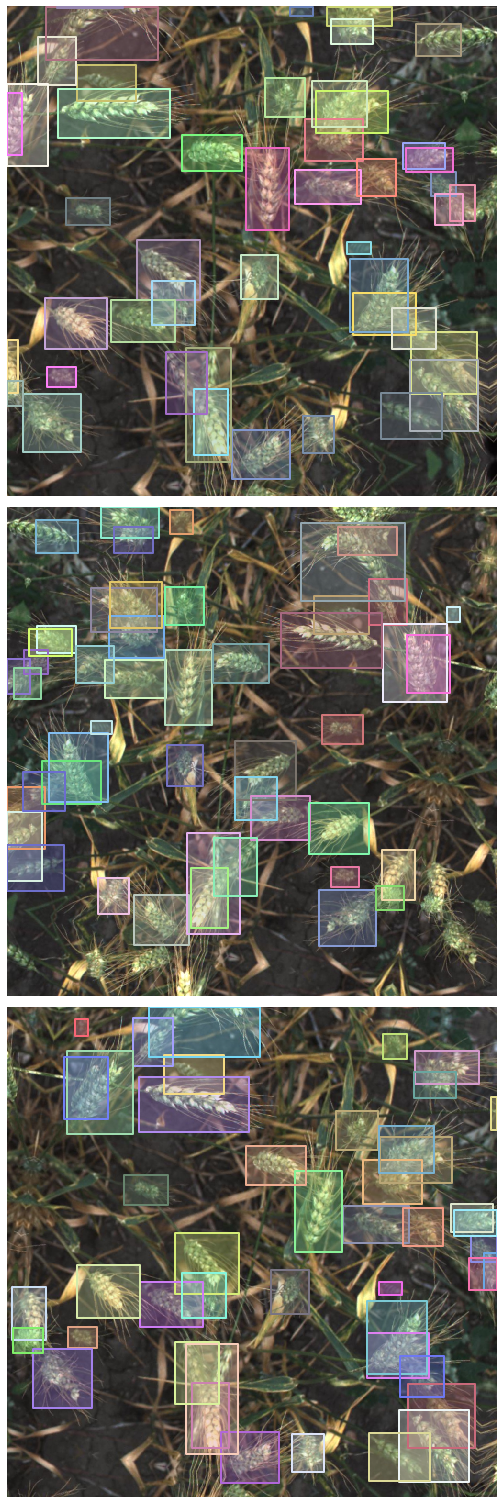

In [12]:
# items = random.choices(train_ds, k=3) # Random items
items = [train_ds[0] for _ in range(3)] # Same item
grid2([partial(show_item, o, label=False) for o in items])

## Define metrics and model

Let's use the standard `COCOMetric`, on our validation dataset.

In [12]:
metrics = [COCOMetric(valid_rs, catmap)]


creating index...
index created!


Since our problem only contain bounding boxes, we're going to use the `FasterRCNN` model.

In [14]:
model = MantisFasterRCNN(len(catmap), metrics=metrics)

## Train!

The training loop is all handled by Lightning.

In [15]:
trainer = Trainer(max_epochs=1, gpus=1, log_gpu_memory=True)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(model, train_dl, valid_dl)


    | Name                                  | Type                     | Params
-------------------------------------------------------------------------------
0   | m                                     | FasterRCNN               | 41 M  
1   | m.transform                           | GeneralizedRCNNTransform | 0     
2   | m.backbone                            | BackboneWithFPN          | 26 M  
3   | m.backbone.body                       | IntermediateLayerGetter  | 23 M  
4   | m.backbone.body.conv1                 | Conv2d                   | 9 K   
5   | m.backbone.body.bn1                   | FrozenBatchNorm2d        | 0     
6   | m.backbone.body.relu                  | ReLU                     | 0     
7   | m.backbone.body.maxpool               | MaxPool2d                | 0     
8   | m.backbone.body.layer1                | Sequential               | 212 K 
9   | m.backbone.body.layer1.0              | Bottleneck               | 73 K  
10  | m.backbone.body.layer1.0.conv1   

/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.

## Visualize results

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs

/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


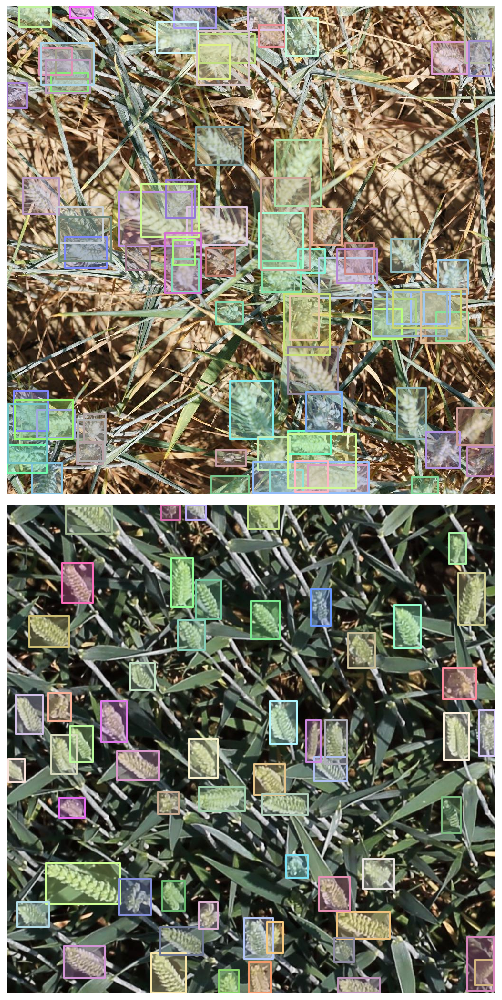

In [16]:
rs = random.choices(rvalid, k=2)
ims,preds = model.predict(rs=rs)
show_preds(ims, preds)